In [1]:
filepath ='/Datasets/Ghouls, Goblins and Ghosts/train.csv'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')

In [4]:
train.head()

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
0,0,0.354512,0.350839,0.465761,0.781142,clear,Ghoul
1,1,0.575560,0.425868,0.531401,0.439899,green,Goblin
2,2,0.467875,0.354330,0.811616,0.791225,black,Ghoul
3,4,0.776652,0.508723,0.636766,0.884464,black,Ghoul
4,5,0.566117,0.875862,0.418594,0.636438,green,Ghost


In [5]:
train.describe(include = 'all')

,id,bone_length,rotting_flesh,hair_length,has_soul,color,type
count,371.000000,371.000000,371.000000,371.000000,371.000000,371,371
unique,NaN,NaN,NaN,NaN,NaN,6,3
top,NaN,NaN,NaN,NaN,NaN,white,Ghoul
freq,NaN,NaN,NaN,NaN,NaN,137,129
mean,443.676550,0.434160,0.506848,0.529114,0.471392,NaN,NaN
std,263.222489,0.132833,0.146358,0.169902,0.176129,NaN,NaN
min,0.000000,0.061032,0.095687,0.134600,0.009402,NaN,NaN
25%,205.500000,0.340006,0.414812,0.407428,0.348002,NaN,NaN
50%,458.000000,0.434891,0.501552,0.538642,0.466372,NaN,NaN
75%,678.500000,0.517223,0.603977,0.647244,0.600610,NaN,NaN


Text(0.5, 1.0, 'has_soul')

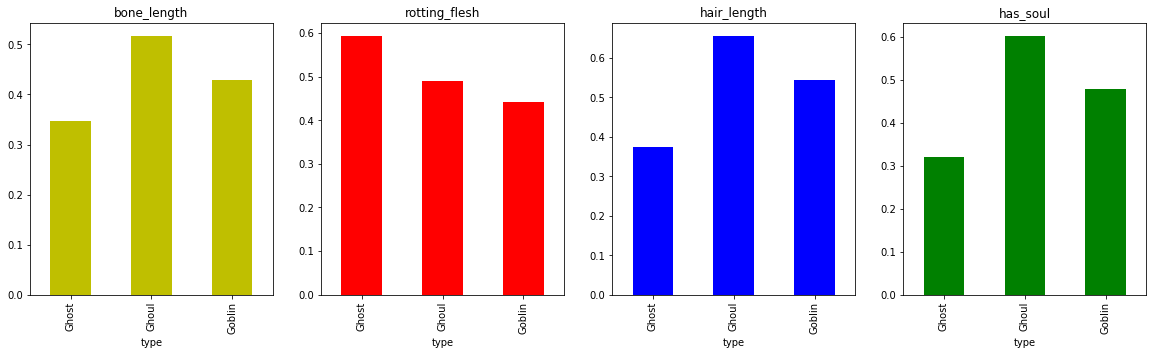

In [6]:
plt.subplot(1,4,1)
train.groupby('type').mean()['bone_length'].plot(kind = 'bar',figsize = (20,5),color ='y')
plt.title('bone_length')
plt.subplot(1,4,2)
train.groupby('type').mean()['rotting_flesh'].plot(kind = 'bar',figsize = (20,5),color ='r')
plt.title('rotting_flesh')
plt.subplot(1,4,3)
train.groupby('type').mean()['hair_length'].plot(kind = 'bar',figsize = (20,5),color ='b')
plt.title('hair_length')
plt.subplot(1,4,4)
train.groupby('type').mean()['has_soul'].plot(kind = 'bar',figsize = (20,5),color ='g')
plt.title('has_soul')

C:\Users\91891\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\91891\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


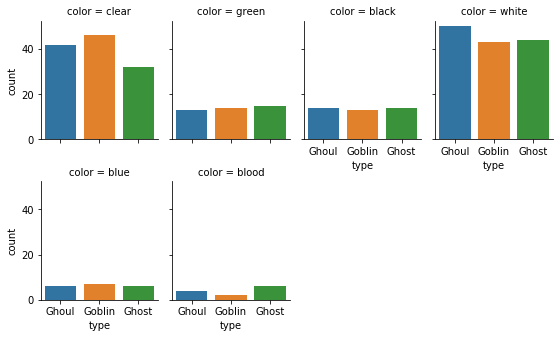

In [7]:
sns.factorplot("type", col="color", col_wrap=4, data=train, kind="count", size=2.4, aspect=.8)

The colors seem to be almost evenly distributed among the different target classes. So, color doesn't seem to be a good predictor.

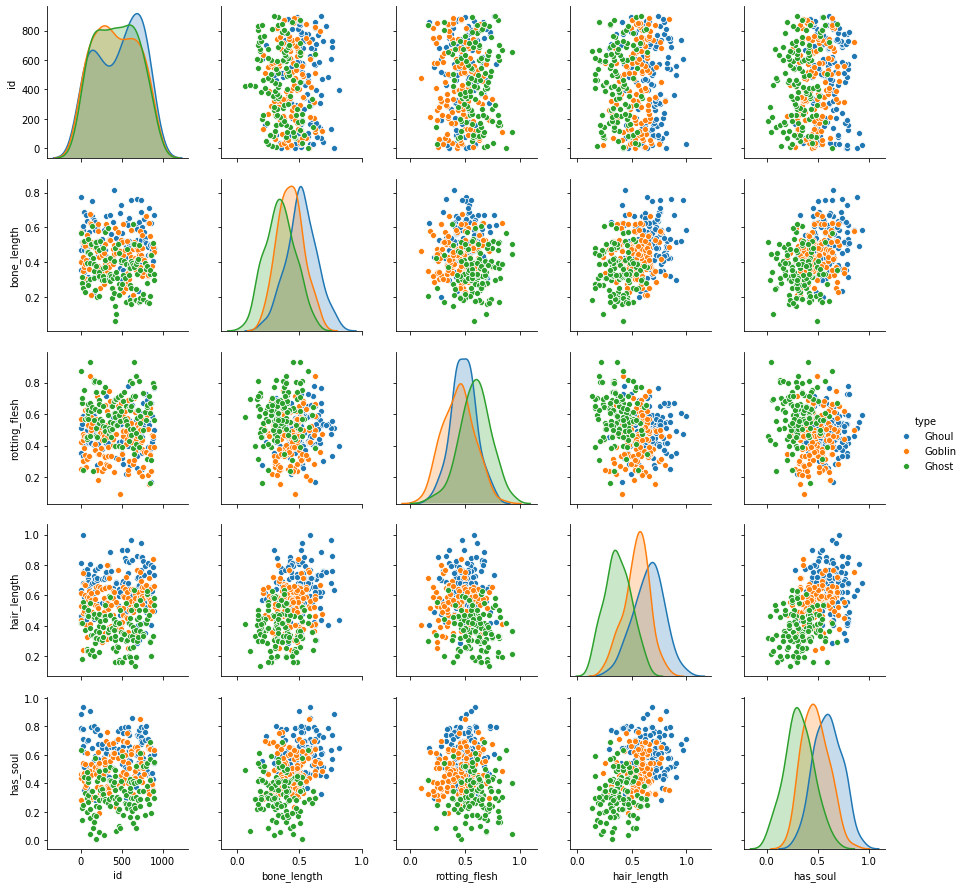

In [8]:
sns.pairplot(train,hue = 'type')

Here, feature pairs like (hair_length,has_soul) and (bone_length,has_soul) seem to have a positive correlation. This can be useful in prediction. One of the advantages of having correlated pairs like these is that we can make new variables by multiplying the pairs.

In [9]:
train['soul_bone'] = train['has_soul']*train['bone_length']
test['soul_bone'] = test['has_soul']*test['bone_length']
train['soul_hair'] = train['has_soul']*train['hair_length']
test['soul_hair'] = test['has_soul']*test['hair_length']
train['soul_bone_hair'] = train['has_soul']*train['bone_length']*train['hair_length']
test['soul_bone_hair'] = test['has_soul']*test['bone_length']*test['hair_length']

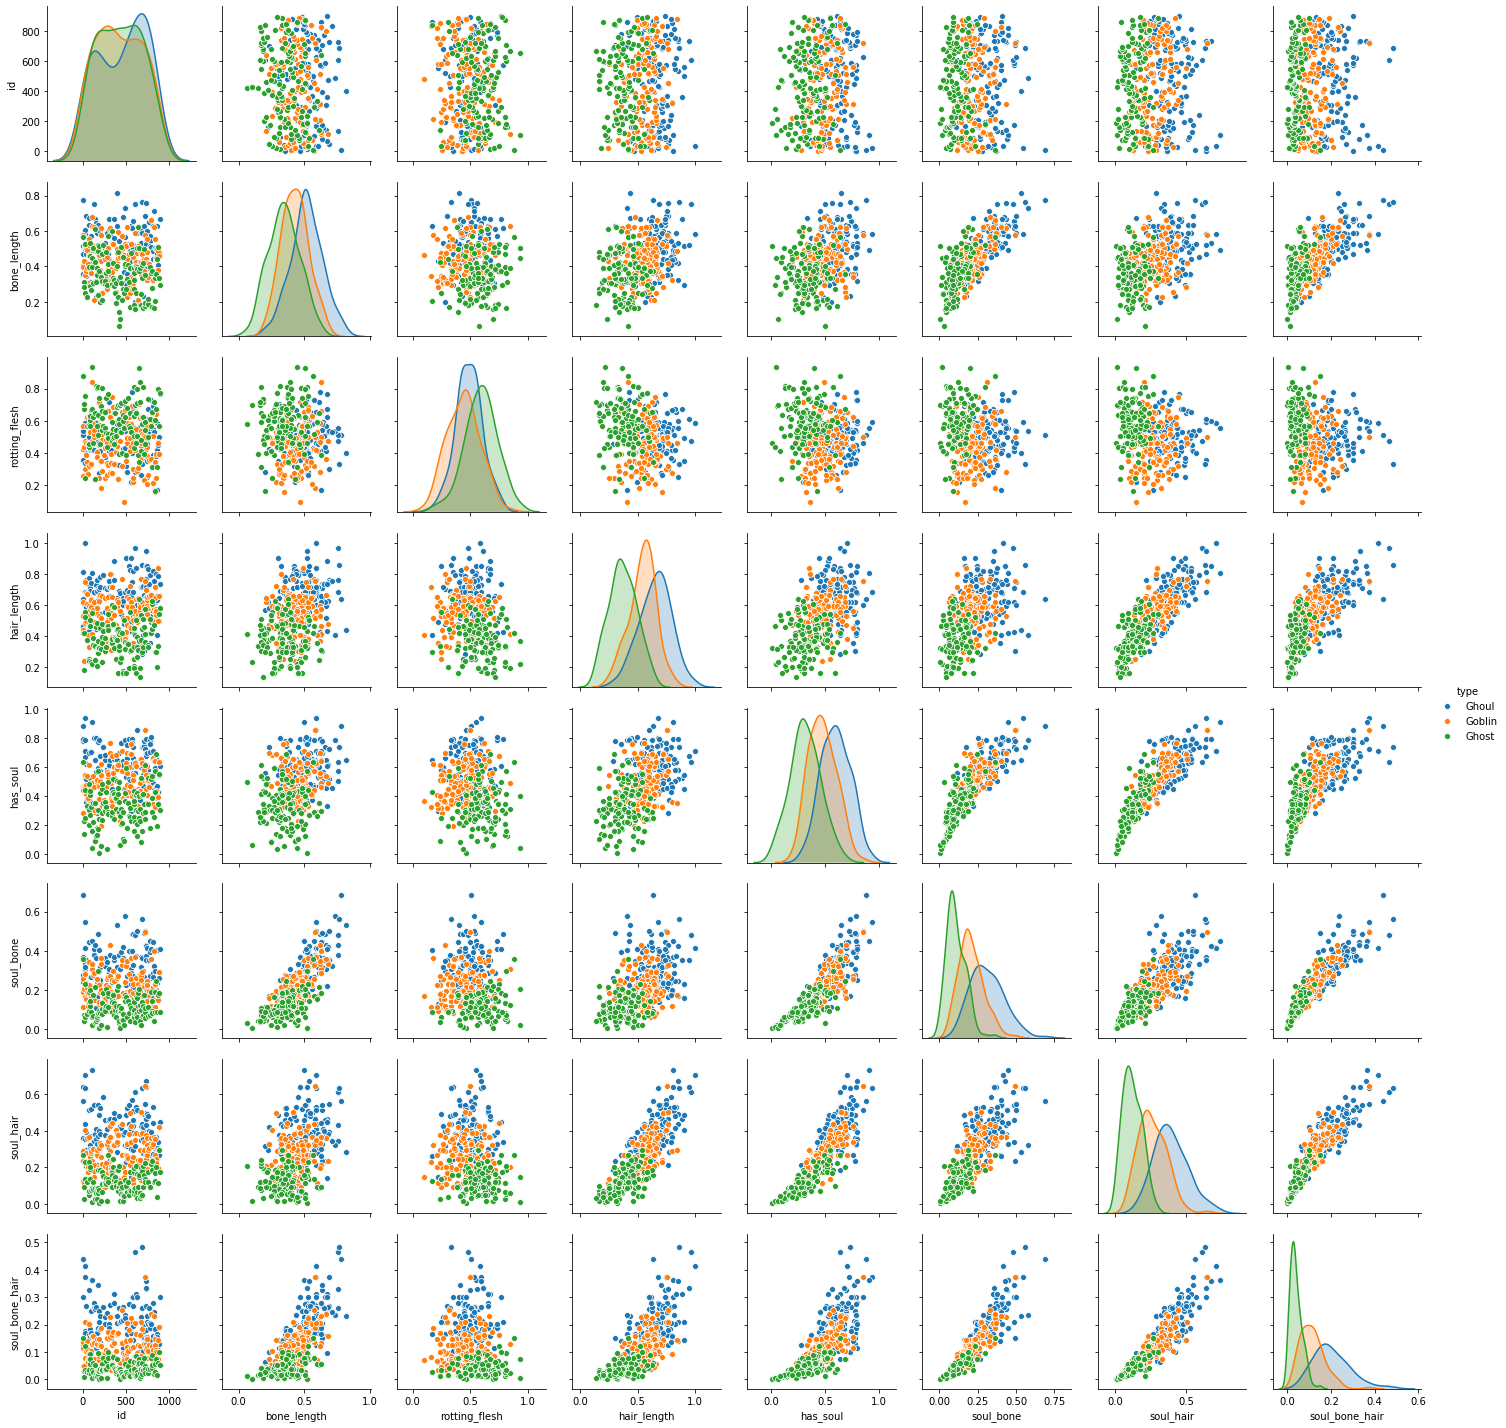

In [10]:
sns.pairplot(train,hue = 'type')

In [11]:
test_id = test['id']
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

Data Selection

In [12]:
#train data
dummies = pd.get_dummies(train['color'],drop_first = False)
dummies = dummies.add_prefix('{}_'.format('color'))
train.drop(['color'],axis = 1,inplace = True)
train = train.join(dummies)
#test data
dummies = pd.get_dummies(test['color'],drop_first = False)
dummies = dummies.add_prefix('{}_'.format('color'))
test.drop(['color'],axis = 1,inplace = True)
test = test.join(dummies)

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(train['type'].values)
train.drop(['type'],axis = 1,inplace = True)

In [14]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
selector = RandomForestClassifier(n_estimators = 200)
selector.fit(train,y)
indices = np.argsort(selector.feature_importances_)[::-1]
indices

array([ 6,  5,  2,  4,  1,  3,  0, 10, 12, 11,  9,  7,  8], dtype=int64)

In [15]:
best_features = []
for i in range(train.shape[1]):
    print('{}. {}'.format(i+1,train.columns[indices[i]]))
    best_features.append(train.columns[indices[i]])

1. soul_bone_hair
2. soul_hair
3. hair_length
4. soul_bone
5. rotting_flesh
6. has_soul
7. bone_length
8. color_clear
9. color_white
10. color_green
11. color_blue
12. color_black
13. color_blood


The color attributes seem to be less important compared to the other ones. Now we have to find the optimum quantity of features

Text(0.5, 1.0, 'CV Score Comparison')

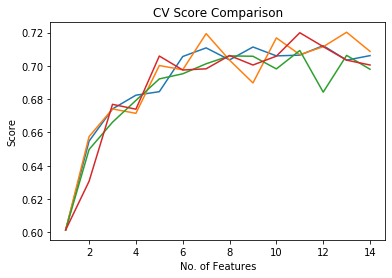

In [16]:
from sklearn.model_selection import cross_val_score
for x in range(4):
    scores = []
    for i in range(1,15):
        dtc = RandomForestClassifier(n_estimators = 100)
        scoreCV = cross_val_score(dtc, train[best_features[0:i]], y, cv= 10)
        scores.append(np.mean(scoreCV))
    plt.plot(range(1,15),scores)
plt.xlabel('No. of Features')
plt.ylabel('Score')
plt.title('CV Score Comparison')

Seems like the accuracy almost flatlines after 6. But for good measure I will only ignore the features related to color. So, we have 7 features in total

In [17]:
newtrain = train.drop(best_features[7::],axis = 1)
newtest = test.drop(best_features[7::],axis = 1)

In [18]:
newtrain.head()

,bone_length,rotting_flesh,hair_length,has_soul,soul_bone,soul_hair,soul_bone_hair
0,0.354512,0.350839,0.465761,0.781142,0.276924,0.363825,0.128980
1,0.575560,0.425868,0.531401,0.439899,0.253188,0.233763,0.134545
2,0.467875,0.354330,0.811616,0.791225,0.370195,0.642171,0.300456
3,0.776652,0.508723,0.636766,0.884464,0.686921,0.563196,0.437408
4,0.566117,0.875862,0.418594,0.636438,0.360298,0.266409,0.150818


## Modeling

Now that I have my features, its time to focus on the modeling. I'll be looking at different ML algorithms and I will use Hyperparameter tuning to find the best possible model

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(newtrain,y,test_size = 0.2,random_state = 36)

RandomForestClassifier
Ill be dividing the GridSearchCV to two cells to minimize load

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
rfc = RandomForestClassifier(max_depth = 100,                                
                                min_samples_split =2,
                                min_weight_fraction_leaf = 0.0,
                                max_leaf_nodes = 40)

parameter_grid = {'n_estimators' : [10, 20, 150],
                  'criterion' : ['gini', 'entropy'],
                  'max_features' : ['auto', 'sqrt', 'log2']
                 }
grid_search = GridSearchCV(rfc, param_grid=parameter_grid, scoring='accuracy', cv=StratifiedKFold(5))
grid_search.fit(newtrain, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7277628032345014
Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 10}


C:\Users\91891\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [21]:
rfc = RandomForestClassifier(criterion = 'gini',                             
                                max_features = 'auto',
                                n_estimators = 10)

parameter_grid = {'max_depth' : [None,5,100],                                
                                'min_samples_split' :[2,5,7],
                                'min_weight_fraction_leaf' : [0.0,0.1],
                                'max_leaf_nodes' : [40,60]
                 }
grid_search = GridSearchCV(rfc, param_grid=parameter_grid, scoring='accuracy', cv=StratifiedKFold(5))
grid_search.fit(newtrain, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7223719676549866
Best parameters: {'max_depth': None, 'max_leaf_nodes': 40, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0}


C:\Users\91891\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CalibratedClassifierCV

In [22]:
from sklearn.calibration import CalibratedClassifierCV
rfc = RandomForestClassifier(criterion = 'gini',                             
                                max_features = 'auto',
                                n_estimators = 20,
                                max_depth = 5,                                
                                min_samples_split =5,
                                min_weight_fraction_leaf = 0.1,
                                max_leaf_nodes = 40
                            )
calibrated_rfc = CalibratedClassifierCV(rfc,method='sigmoid', cv=5)
calibrated_rfc.fit(X_train,y_train)
cal_predict = calibrated_rfc.predict_proba(X_test)

In [23]:
sum(pd.DataFrame(cal_predict,columns = le.classes_).idxmax(axis = 1)==le.inverse_transform(y_test))/len(y_test)

0.7066666666666667

Now let's try Support Vector Machines

In [24]:
from sklearn.svm import SVC
svc = SVC(kernel = 'linear')
svc.fit(X_train,y_train)
svm_predict = svc.predict(X_test)
print('Validation Score: {}'.format(sum((svm_predict) == (y_test))/len(y_test)))

Validation Score: 0.72


#### Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter = 1000)
parameter_grid = {'solver' : ['newton-cg', 'lbfgs'],
                  'multi_class' : ['ovr', 'multinomial'],
                  'C' : [0.005, 0.01, 1, 10, 100, 1000],
                  'tol': [0.0001, 0.001, 0.005],
                 }
grid_search = GridSearchCV(lr,param_grid=parameter_grid,cv=StratifiedKFold(5))
grid_search.fit(X_train,y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.7635135135135135
Best parameters: {'C': 1, 'multi_class': 'multinomial', 'solver': 'newton-cg', 'tol': 0.0001}


C:\Users\91891\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [26]:
lr_opt = LogisticRegression(solver = 'newton-cg',
                            tol = 0.0001,
                            multi_class = 'multinomial',
                            C = 1,
                            max_iter = 1000)
lr_opt.fit(X_train,y_train)
lr_predict = lr_opt.predict_proba(X_test)
print(np.mean(pd.DataFrame(lr_predict,columns = le.classes_).idxmax(axis = 1).values==le.inverse_transform(y_test)))

0.76


In [27]:
#soft models
from sklearn.naive_bayes import GaussianNB
clf = RandomForestClassifier(criterion = 'gini',                             
                                max_features = 'auto',
                                n_estimators = 20,
                                max_depth = 5,                                
                                min_samples_split =5,
                                min_weight_fraction_leaf = 0.1,
                                max_leaf_nodes = 40
                            )
s_calibrated_clf = CalibratedClassifierCV(clf, method='sigmoid', cv=5)
s_lr = LogisticRegression(solver = 'newton-cg',
                            tol = 0.0001,
                            multi_class = 'multinomial',
                            C = 1,
                            max_iter = 1000)
s_GaussianNB = GaussianNB()

In [28]:
#hard models
h_calibrated_clf = CalibratedClassifierCV(RandomForestClassifier())
h_lr = LogisticRegression()
h_GaussianNB = GaussianNB()

For Soft voting the models need to be fine tuned.

In [29]:
from sklearn.ensemble import VotingClassifier
Vclf1 = VotingClassifier(estimators=[('LR', h_lr), ('CRF', h_calibrated_clf),
                                     ('GNB', h_GaussianNB)], voting='hard')
Vclf = VotingClassifier(estimators=[('LR', s_lr), ('CRF', s_calibrated_clf),
                                     ('GNB', s_GaussianNB)], voting='soft', weights=[1,1,1])

In [30]:
hard_predict = le.inverse_transform(Vclf1.fit(newtrain, y).predict(newtest))
soft_predict = le.inverse_transform(Vclf.fit(newtrain, y).predict(newtest))

C:\Users\91891\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\91891\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\91891\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\91891\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\91891\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py

In [45]:
lr_pre = lr_opt.predict(newtest)
lr_final = pd.DataFrame({'id':test_id,'type':le.inverse_transform(lr_pre)})

In [49]:
hard_final = pd.DataFrame({'id':test_id,'type':hard_predict})
soft_final = pd.DataFrame({'id':test_id,'type':soft_predict})

In [53]:
lr_final.to_csv('lr_submission.csv',index = False)
hard_final.to_csv('hard_submission.csv',index = False)
soft_final.to_csv('soft_submission.csv',index = False)